In [9]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import deepcopy


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")
SEED = 1234
torch.manual_seed(SEED); np.random.seed(SEED)

# Equal total steps for both runs
TOTAL_STEPS = 10000
ADAM_STEPS  = 8000
LBFGS_STEPS = TOTAL_STEPS - ADAM_STEPS  # 2000

# Collocation points per iteration
N_POINTS = 2000

# Base learning rates
ADAM_LR_BASE  = 1e-3
LBFGS_LR_BASE = 1.0   # initial step-size scale for LBFGS (PyTorch uses this)

# Cosine scheduler settings
# Adam: cosine from ADAM_LR_BASE -> ADAM_LR_MIN over its horizon
ADAM_LR_MIN = 1e-5
# LBFGS: cosine from LBFGS_LR_BASE -> LBFGS_LR_MIN over its horizon
LBFGS_LR_MIN = 0.2

W_PDE, W_BC = 1.0, 50.0

# Domain / physics constants (from your code)
L, W = 1.0, 0.5
lambda_, mu = 5e9, 5e9
h = 1.0
sf = 1e9

# =========================
# Load FEA grid & targets
# =========================
def load_csv():
    return pd.read_csv("/Users/murat/Downloads/data.csv", skiprows=8)  # or /mnt/data/data.csv if running here

df = load_csv()
print(df.columns)   # just to confirm once

# --- Extract tensors ---
x_fea = torch.tensor(df["X"].values, dtype=torch.float32).reshape(-1, 1).to(DEVICE)
y_fea = torch.tensor(df["Y"].values, dtype=torch.float32).reshape(-1, 1).to(DEVICE)

# Here u1 → u_x_actual, u2 → u_y_actual
ux_true = torch.tensor(df["u1 (cm)"].values, dtype=torch.float32).reshape(-1, 1).to(DEVICE)
uy_true = torch.tensor(df["u2 (cm)"].values, dtype=torch.float32).reshape(-1, 1).to(DEVICE)

# =========================
# Model (unchanged)
# =========================
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)  # [u, v, u_x, u_y, v_x, v_y]
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, grad_outputs=torch.ones_like(u_net),
                                   retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, grad_outputs=torch.ones_like(u_net),
                                   retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, grad_outputs=torch.ones_like(v_net),
                                   retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, grad_outputs=torch.ones_like(v_net),
                                   retain_graph=True, create_graph=True)[0]
    Exx = u_x_true
    Eyy = v_y_true
    Exy = 0.5 * (u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

def stress_tensor(Exx, Eyy, Exy):
    TrE = Exx + Eyy
    Sxx = h * ((lambda_/sf) * TrE + 2 * (mu/sf) * Exx)
    Syy = h * ((lambda_/sf) * TrE + 2 * (mu/sf) * Eyy)
    Sxy = h * (2 * (mu/sf) * Exy)
    return Sxx, Syy, Sxy

def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:,i:i+1] for i in range(6))

    u_x_true, u_y_true, v_x_true, v_y_true, _, _, _ = strain_tensor(u_net, v_net, x, y)

    # compatibility loss (predicted first derivatives vs autograd)
    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    # stresses from network first derivatives
    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    # equilibrium residuals
    Sxx_x = torch.autograd.grad(Sxx, x, grad_outputs=torch.ones_like(Sxx),
                                retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, grad_outputs=torch.ones_like(Sxy),
                                retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, grad_outputs=torch.ones_like(Syy),
                                retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, grad_outputs=torch.ones_like(Sxy),
                                retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad

def boundary_condition_loss(model):
    # A: x=-L/2, u=v=0
    y_A = torch.linspace(-W/2, W/2, 500, device=DEVICE).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)

    # D: x=+L/2, u_x=0.02L, u_y=0
    x_D = L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A)
    u_x_D, u_y_D = out_D[:,0:1], out_D[:,1:2]
    loss_D = torch.mean((u_x_D - 0.02*L)**2 + (u_y_D)**2)

    # C: y=-W/2 traction-free (Syy=0, Sxy=0)
    x_C = torch.linspace(-L/2, L/2, 200, device=DEVICE).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    # B: y=+W/2 traction-free (Syy=0, Sxy=0)
    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

# =========================
# Evaluation on FEA grid
# =========================
@torch.no_grad()
def eval_displacement_and_accuracy(model):
    model.eval()
    out = model(x_fea, y_fea)
    u_pred = out[:,0:1]
    v_pred = out[:,1:2]
    # vector displacement relative L2 accuracy
    num = torch.linalg.norm(torch.cat([u_pred-ux_true, v_pred-uy_true], dim=1))
    den = torch.linalg.norm(torch.cat([ux_true, uy_true], dim=1)) + 1e-12
    acc = 1.0 - (num/den).item()
    ux_rel = (torch.linalg.norm(u_pred-ux_true) / (torch.linalg.norm(ux_true)+1e-12)).item()
    uy_rel = (torch.linalg.norm(v_pred-uy_true) / (torch.linalg.norm(uy_true)+1e-12)).item()
    return acc, ux_rel, uy_rel

def sample_collocation(n_points):
    x = torch.rand(n_points,1, device=DEVICE)*L - L/2
    y = torch.rand(n_points,1, device=DEVICE)*W - W/2
    return x, y

@torch.no_grad()
def eval_metrics(model):
    """Returns (acc, relL2, mse) on the FEA grid."""
    model.eval()
    out = model(x_fea, y_fea)
    u_pred = out[:, 0:1]
    v_pred = out[:, 1:2]
    num = torch.linalg.norm(torch.cat([u_pred-ux_true, v_pred-uy_true], dim=1))
    den = torch.linalg.norm(torch.cat([ux_true, uy_true], dim=1)) + 1e-12
    acc = 1.0 - (num/den).item()
    relL2 = 1.0 - acc
    mse = torch.mean((u_pred-ux_true)**2 + (v_pred-uy_true)**2).item()
    return acc, relL2, mse


# =========================
# Cosine LR helpers
# =========================
def cosine_lr(t, T, lr_max, lr_min):
    """Cosine decay from lr_max -> lr_min over T steps, at step t (1-based or 0-based ok)."""
    if T <= 1:
        return lr_min
    cos_inner = np.pi * min(t, T) / T
    return lr_min + 0.5*(lr_max - lr_min)*(1 + np.cos(cos_inner))

# =========================
# Training loops (with LR schedules)
# =========================
def train_adam(model, steps, n_points, lr_base=ADAM_LR_BASE, lr_min=ADAM_LR_MIN, tag="[Adam]"):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr_base)
    loss_hist, acc_hist, relL2_hist, mse_hist = [], [], [], []

    for it in range(1, steps+1):
        # cosine LR
        lr_t = cosine_lr(it, steps, lr_base, lr_min)
        for g in opt.param_groups: g['lr'] = lr_t

        x, y = sample_collocation(n_points)
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model)
        loss = W_PDE*lp + W_BC*lb

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        loss_hist.append(loss.item())
        acc, relL2, mse = eval_metrics(model)
        acc_hist.append(acc); relL2_hist.append(relL2); mse_hist.append(mse)

        if it % 500 == 0:
            print(f"{tag} iter {it:5d} | lr={lr_t:.2e} | loss={loss.item():.3e} | "
                  f"acc={acc:.4f} | relL2={relL2:.3e} | mse={mse:.3e}")

    return {"loss": loss_hist, "acc": acc_hist, "relL2": relL2_hist, "mse": mse_hist}


def train_lbfgs_with_schedule(model, steps, n_points,
                              lr_base=LBFGS_LR_BASE, lr_min=LBFGS_LR_MIN):
    model.train()
    loss_hist, acc_hist, relL2_hist, mse_hist = [], [], [], []

    for it in range(1, steps+1):
        lr_t = cosine_lr(it, steps, lr_base, lr_min)
        opt = torch.optim.LBFGS(
            model.parameters(),
            lr=lr_t, max_iter=1,
            line_search_fn="strong_wolfe",
            tolerance_grad=1e-10, tolerance_change=1e-12,
            history_size=100
        )
        def closure():
            opt.zero_grad(set_to_none=True)
            x, y = sample_collocation(n_points)
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model)
            loss = W_PDE*lp + W_BC*lb
            loss.backward()
            return loss

        loss = opt.step(closure)

        loss_hist.append(loss.item())
        acc, relL2, mse = eval_metrics(model)
        acc_hist.append(acc); relL2_hist.append(relL2); mse_hist.append(mse)

        if it % 200 == 0:
            print(f"[LBFGS] iter {it:5d} | lr={lr_t:.2e} | loss={loss.item():.3e} | "
                  f"acc={acc:.4f} | relL2={relL2:.3e} | mse={mse:.3e}")

    return {"loss": loss_hist, "acc": acc_hist, "relL2": relL2_hist, "mse": mse_hist}


def pad_to_length(arr, L):
    if len(arr) >= L: return arr[:L]
    if len(arr) == 0: return [0.0]*L
    return arr + [arr[-1]]*(L - len(arr))

# =========================
# Run experiments
# =========================
base = PINN().to(DEVICE)
base_state = deepcopy(base.state_dict())

# Case A: Pure Adam (15k with cosine LR)
model_adam = PINN().to(DEVICE)
model_adam.load_state_dict(deepcopy(base_state))
hist_adam_full = train_adam(model_adam, TOTAL_STEPS, N_POINTS, lr_base=ADAM_LR_BASE, lr_min=ADAM_LR_MIN, tag="[Adam-only]")

# Case B: Adam (10k with cosine) + LBFGS (5k with cosine) = 15k
model_hybrid = PINN().to(DEVICE)
model_hybrid.load_state_dict(deepcopy(base_state))
hist_adam_phase = train_adam(model_hybrid, ADAM_STEPS, N_POINTS, lr_base=ADAM_LR_BASE, lr_min=ADAM_LR_MIN, tag="[Hybrid: Adam]")
hist_lbfgs_phase = train_lbfgs_with_schedule(model_hybrid, LBFGS_STEPS, N_POINTS,
                                             lr_base=LBFGS_LR_BASE, lr_min=LBFGS_LR_MIN)

# Make the hybrid history exactly 15k long
hybrid_loss  = hist_adam_phase["loss"]  + pad_to_length(hist_lbfgs_phase["loss"],  LBFGS_STEPS)
hybrid_acc   = hist_adam_phase["acc"]   + pad_to_length(hist_lbfgs_phase["acc"],   LBFGS_STEPS)
hybrid_relL2 = hist_adam_phase["relL2"] + pad_to_length(hist_lbfgs_phase["relL2"], LBFGS_STEPS)
hybrid_mse   = hist_adam_phase["mse"]   + pad_to_length(hist_lbfgs_phase["mse"],   LBFGS_STEPS)

# Sanity: ensure equal lengths
assert len(hist_adam_full["loss"]) == TOTAL_STEPS
assert len(hybrid_loss)            == TOTAL_STEPS
assert len(hist_adam_full["acc"])  == TOTAL_STEPS
assert len(hybrid_acc)             == TOTAL_STEPS


# =========================
# Final metrics on FEA grid
# =========================
accA, uxA, uyA = eval_displacement_and_accuracy(model_adam)
accH, uxH, uyH = eval_displacement_and_accuracy(model_hybrid)
print("\n=== Final metrics on FEA grid ===")
print(f"Adam (15k, cosine):           acc={accA:.6f} | ux_rel_err={uxA:.6f} | uy_rel_err={uyA:.6f}")
print(f"Adam(10k)+LBFGS(5k, cosine):  acc={accH:.6f} | ux_rel_err={uxH:.6f} | uy_rel_err={uyH:.6f}")

# Save weights
torch.save(model_adam.state_dict(),   "pinn_elasticity_adam_15k_cosine.pth")
torch.save(model_hybrid.state_dict(), "pinn_elasticity_adam10k_lbfgs5k_cosine.pth")
print("\nSaved:")
print(" - pinn_elasticity_adam_15k_cosine.pth")
print(" - pinn_elasticity_adam10k_lbfgs5k_cosine.pth")
print("Plots saved in figs/: loss_vs_iter.png, accuracy_vs_iter.png")


Using device: mps
Index(['X', 'Y', 'u1 (cm)', 'u2 (cm)', 'E11 (1)', 'E22 (1)', 'E12 (1)',
       'S11 (N/m)', 'S22 (N/m)', 'S12 (N/m)', 'We (N/m)', 'fx (N/m)',
       'fy (N/m)', 'lambda (Pa)', 'mu (Pa)', 'W (cm)', 'L (cm)'],
      dtype='object')
[Adam-only] iter   500 | lr=9.94e-04 | loss=2.285e-03 | acc=0.8287 | relL2=1.713e-01 | mse=3.973e-06
[Adam-only] iter  1000 | lr=9.76e-04 | loss=1.128e-03 | acc=0.8557 | relL2=1.443e-01 | mse=2.819e-06
[Adam-only] iter  1500 | lr=9.46e-04 | loss=4.602e-04 | acc=0.8845 | relL2=1.155e-01 | mse=1.806e-06
[Adam-only] iter  2000 | lr=9.05e-04 | loss=1.793e-04 | acc=0.9126 | relL2=8.741e-02 | mse=1.035e-06
[Adam-only] iter  2500 | lr=8.55e-04 | loss=8.363e-05 | acc=0.9364 | relL2=6.361e-02 | mse=5.479e-07
[Adam-only] iter  3000 | lr=7.96e-04 | loss=5.463e-05 | acc=0.9436 | relL2=5.641e-02 | mse=4.310e-07
[Adam-only] iter  3500 | lr=7.30e-04 | loss=4.038e-05 | acc=0.9592 | relL2=4.081e-02 | mse=2.255e-07
[Adam-only] iter  4000 | lr=6.58e-04 | loss=3

Final Model Accuracy on FEA grid:
Adam Model:   Accuracy=0.978815, ux_rel_err=0.007002, uy_rel_err=0.265076
Hybrid Model: Accuracy=0.975912, ux_rel_err=0.008378, uy_rel_err=0.299421


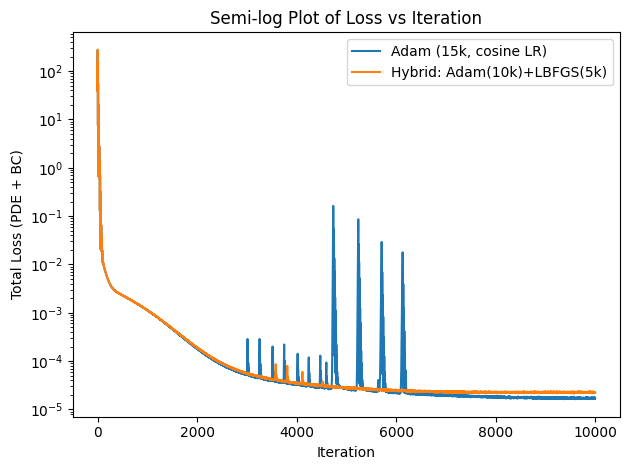

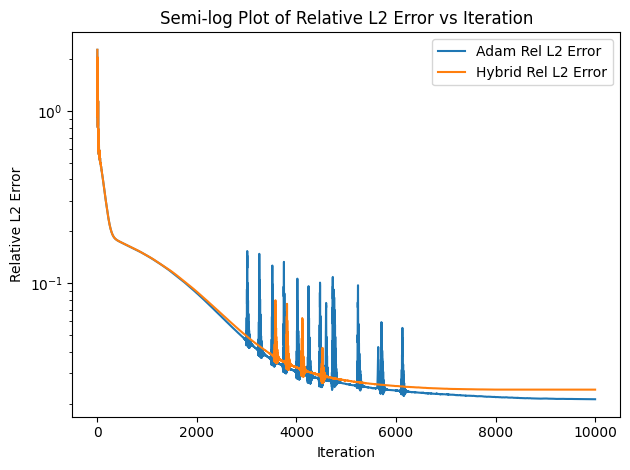

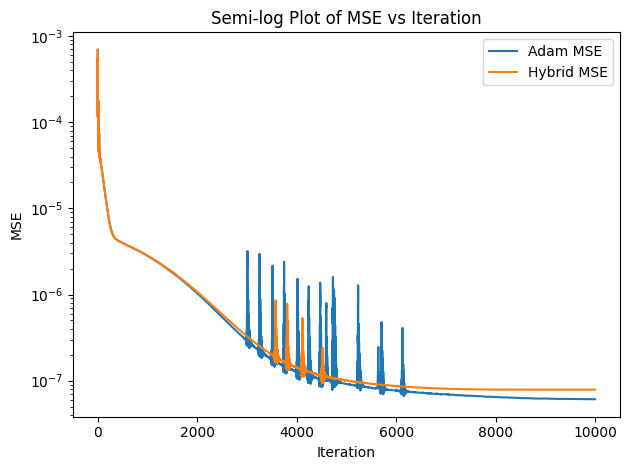

In [10]:
# Evaluate and print final model accuracy on the FEA grid
accA, uxA, uyA = eval_displacement_and_accuracy(model_adam)
accH, uxH, uyH = eval_displacement_and_accuracy(model_hybrid)

print("Final Model Accuracy on FEA grid:")
print(f"Adam Model:   Accuracy={accA:.6f}, ux_rel_err={uxA:.6f}, uy_rel_err={uyA:.6f}")
print(f"Hybrid Model: Accuracy={accH:.6f}, ux_rel_err={uxH:.6f}, uy_rel_err={uyH:.6f}")

iters = np.arange(1, TOTAL_STEPS+1)

# 1) Semi-log plot of loss vs iteration
plt.figure()
plt.semilogy(iters, hist_adam_full["loss"], label="Adam (15k, cosine LR)")
plt.semilogy(iters, hybrid_loss,           label="Hybrid: Adam(10k)+LBFGS(5k)")
plt.xlabel("Iteration")
plt.ylabel("Total Loss (PDE + BC)")
plt.title("Semi-log Plot of Loss vs Iteration")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Semi-log plot of Rel L2 error vs iteration (separate figure)
plt.figure()
plt.semilogy(iters, hist_adam_full["relL2"], label="Adam Rel L2 Error")
plt.semilogy(iters, hybrid_relL2,            label="Hybrid Rel L2 Error")
plt.xlabel("Iteration")
plt.ylabel("Relative L2 Error")
plt.title("Semi-log Plot of Relative L2 Error vs Iteration")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Semi-log plot of MSE vs iteration (separate figure)
plt.figure()
plt.semilogy(iters, hist_adam_full["mse"], label="Adam MSE")
plt.semilogy(iters, hybrid_mse,            label="Hybrid MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Semi-log Plot of MSE vs Iteration")
plt.legend()
plt.tight_layout()
plt.show()


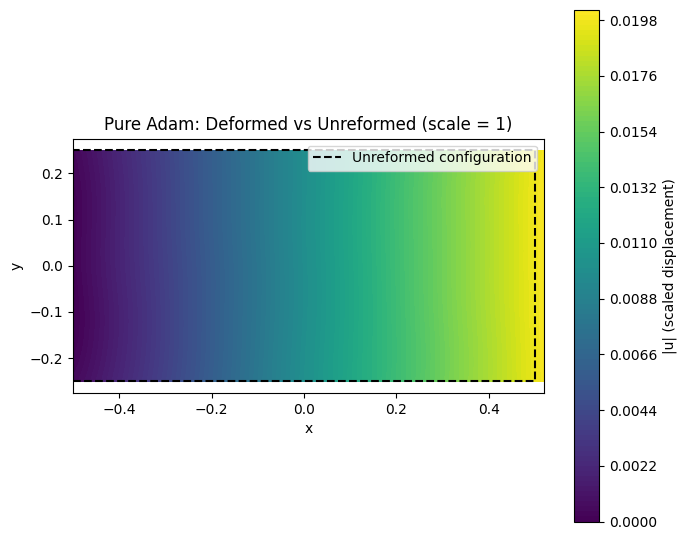

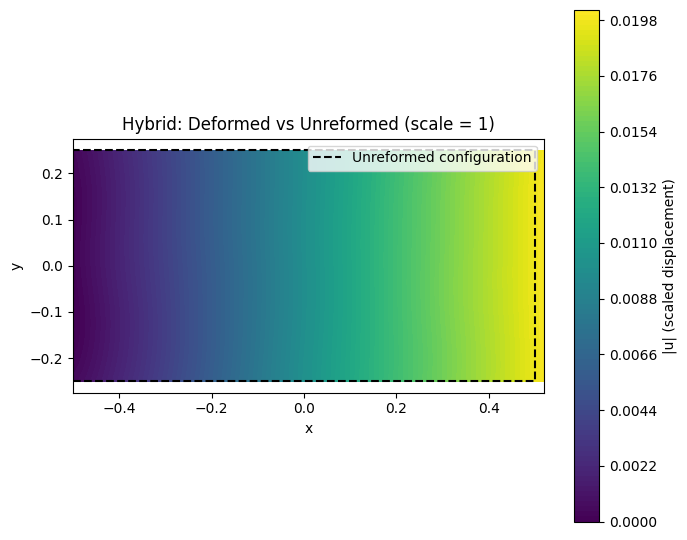

In [ ]:
@torch.no_grad()
def plot_deformed_configuration(model, scale=1.0, title="Deformed vs Unreformed"):

    model.eval()

    # Predict displacements
    x = x_fea.reshape(-1, 1)
    y = y_fea.reshape(-1, 1)
    out = model(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Compute deformed coordinates
    x_def = x + scale * u
    y_def = y + scale * v

    # Convert to NumPy
    x_np = x.squeeze(1).cpu().numpy()
    y_np = y.squeeze(1).cpu().numpy()
    x_def_np = x_def.squeeze(1).cpu().numpy()
    y_def_np = y_def.squeeze(1).cpu().numpy()

    # Displacement magnitude for color
    disp_mag = np.sqrt((scale * u.cpu().numpy())**2 + (scale * v.cpu().numpy())**2)

    # Create triangulation for surface-like plotting (works for unstructured grids)
    triang = tri.Triangulation(x_def_np, y_def_np)

    plt.figure(figsize=(7, 5.5))

    # Plot deformed configuration (colored by displacement magnitude)
    tpc = plt.tricontourf(triang, disp_mag.squeeze(), cmap="viridis", levels=100)
    cbar = plt.colorbar(tpc)
    cbar.set_label("|u| (scaled displacement)")

    # Draw dashed outline of undeformed boundary
    xmin, xmax = x_np.min(), x_np.max()
    ymin, ymax = y_np.min(), y_np.max()
    outline_x = [xmin, xmax, xmax, xmin, xmin]
    outline_y = [ymin, ymin, ymax, ymax, ymin]
    plt.plot(outline_x, outline_y, 'k--', linewidth=1.5, label="Unreformed configuration")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{title} (scale = {scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_deformed_configuration(model_adam, scale=1.0, title="Pure Adam: Deformed vs Unreformed")
plot_deformed_configuration(model_hybrid, scale=1.0, title="Hybrid: Deformed vs Unreformed")
